In [17]:
import os
import tensorflow as tf

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [18]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [19]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [20]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r'D:\git\kaggle\dogs-vs-cats-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1.0/255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [22]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.5844 - acc: 0.6850 - val_loss: 0.4379 - val_acc: 0.8410
Epoch 2/30
2000/2000 [==============================] - 2s 759us/step - loss: 0.4190 - acc: 0.8130 - val_loss: 0.3627 - val_acc: 0.8480
Epoch 3/30
2000/2000 [==============================] - 2s 832us/step - loss: 0.3566 - acc: 0.8505 - val_loss: 0.3195 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 2s 778us/step - loss: 0.3121 - acc: 0.8695 - val_loss: 0.2957 - val_acc: 0.8910
Epoch 5/30
2000/2000 [==============================] - 2s 778us/step - loss: 0.2889 - acc: 0.8785 - val_loss: 0.2824 - val_acc: 0.8950
Epoch 6/30
2000/2000 [==============================] - 2s 811us/step - loss: 0.2701 - acc: 0.8920 - val_loss: 0.2738 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 2s 825us/step - loss: 0.2502 - acc: 0.8990 - val_loss: 0.2638 - val_acc: 0.8950
Ep

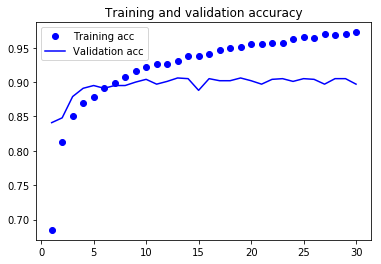

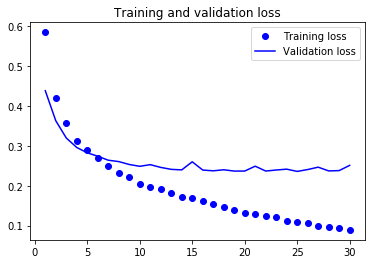

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [28]:
conv_base.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 29s 293ms/step - loss: 0.5945 - acc: 0.6895 - val_loss: 0.4497 - val_acc: 0.8310
Epoch 2/30
100/100 [==============================] - 27s 268ms/step - loss: 0.4800 - acc: 0.7795 - val_loss: 0.3740 - val_acc: 0.8460
Epoch 3/30
100/100 [==============================] - 33s 334ms/step - loss: 0.4256 - acc: 0.8055 - val_loss: 0.3268 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 50s 503ms/step - loss: 0.4002 - acc: 0.8125 - val_loss: 0.3041 - val_acc: 0.8900
Epoch 5/30
100/100 [==============================] - 50s 504ms/step - loss: 0.3881 - acc: 0.8150 - val_loss: 0.2921 - val_acc: 0.8870
Epoch 6/30
100/100 [==============================] - 50s 504ms/step - loss: 0.3729 - acc: 0.8380 - val_loss: 0.2892 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 51s 508ms/step - loss: 0.3611 - acc: 0.8410 - val_lo

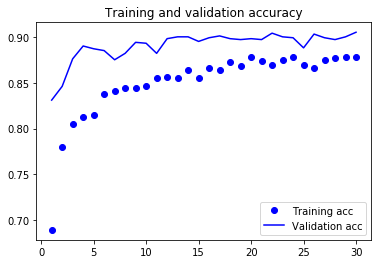

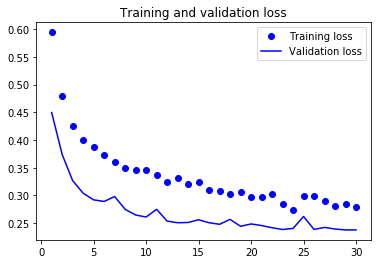

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [32]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 24s 237ms/step - loss: 0.3078 - acc: 0.8680 - val_loss: 0.2272 - val_acc: 0.9010
Epoch 2/100
100/100 [==============================] - 22s 219ms/step - loss: 0.2831 - acc: 0.8725 - val_loss: 0.2089 - val_acc: 0.9080
Epoch 3/100
100/100 [==============================] - 24s 238ms/step - loss: 0.2412 - acc: 0.9005 - val_loss: 0.1926 - val_acc: 0.9190
Epoch 4/100
100/100 [==============================] - 22s 220ms/step - loss: 0.2168 - acc: 0.9080 - val_loss: 0.1920 - val_acc: 0.9180
Epoch 5/100
100/100 [==============================] - 22s 221ms/step - loss: 0.2106 - acc: 0.9105 - val_loss: 0.1926 - val_acc: 0.9200
Epoch 6/100
100/100 [==============================] - 22s 223ms/step - loss: 0.1939 - acc: 0.9185 - val_loss: 0.1972 - val_acc: 0.9180
Epoch 7/100
100/100 [==============================] - 23s 230ms/step - loss: 0.1833 - acc: 0.9255 -

100/100 [==============================] - 63s 633ms/step - loss: 0.0358 - acc: 0.9870 - val_loss: 0.2911 - val_acc: 0.9330
Epoch 61/100
100/100 [==============================] - 60s 601ms/step - loss: 0.0371 - acc: 0.9865 - val_loss: 0.2445 - val_acc: 0.9410
Epoch 62/100
100/100 [==============================] - 54s 540ms/step - loss: 0.0367 - acc: 0.9860 - val_loss: 0.2417 - val_acc: 0.9370
Epoch 63/100
100/100 [==============================] - 50s 499ms/step - loss: 0.0293 - acc: 0.9900 - val_loss: 0.2671 - val_acc: 0.9330
Epoch 64/100
100/100 [==============================] - 61s 606ms/step - loss: 0.0300 - acc: 0.9870 - val_loss: 0.3208 - val_acc: 0.9320
Epoch 65/100
100/100 [==============================] - 59s 593ms/step - loss: 0.0356 - acc: 0.9885 - val_loss: 0.2392 - val_acc: 0.9390
Epoch 66/100
100/100 [==============================] - 59s 594ms/step - loss: 0.0264 - acc: 0.9905 - val_loss: 0.3242 - val_acc: 0.9310
Epoch 67/100
100/100 [==============================] 

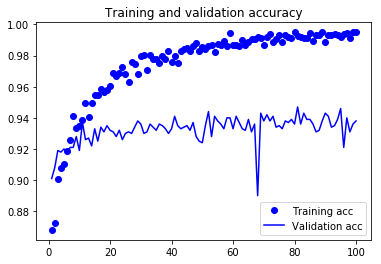

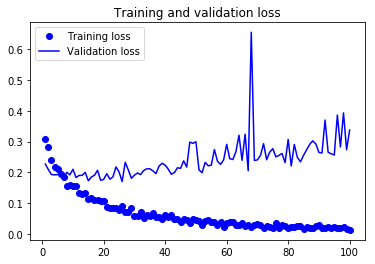

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

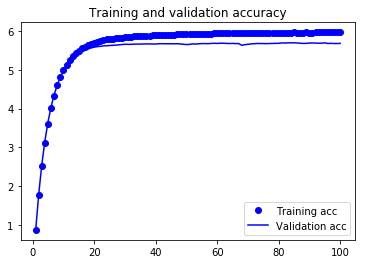

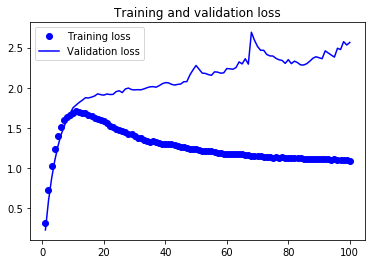

In [34]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point + (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc: ', test_acc)
print('test loss: ', test_loss)

Found 1000 images belonging to 2 classes.
test acc:  0.933999992609024
test loss:  0.3918254041936598
